In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import pickle
import re

import matplotlib.pyplot as plt
import numpy as np

from janelia_core.dataprocessing.dataset import ROIDataset
from keller_zlatic_vnc.whole_brain.whole_brain_stat_functions import test_for_different_than_avg_beta

In [21]:
%matplotlib notebook

## Parameters go here

In [122]:
ps = dict()
ps['save_folder'] = r'\\dm11\bishoplab\projects\keller_vnc\results\single_subject_spont_stats'

# Border values are due to floating point errors 
ps['basic_rs_file'] = 'spont_1_5_5_long_bl_co_4_start_locked_0_6_ece_pre_tc_post_tc.pkl'


ps['ex_dataset_file'] = r'K:\SV4\CW_18-02-15\L1-561nm-openLoop_20180215_163233.corrected\extracted\dataset.pkl'



## Load the basic results

In [123]:
with open(Path(ps['save_folder']) / ps['basic_rs_file'], 'rb') as f:
    basic_rs = pickle.load(f)

In [124]:
beh_trans = basic_rs['beh_trans']
full_stats = basic_rs['full_stats']

## Load the datasest

In [6]:
with open(ps['ex_dataset_file'], 'rb') as f:
    dataset = ROIDataset.from_dict(pickle.load(f))

## Define the stats calculations function

In [164]:
def test_for_diff_than_mean_vls(stats, beh_trans, mn_th = 1e-10):
    """ This is a helper function which calculates post-hoc statistics for each group.
    
    A group are all transitions that start with the same behavior. 
    
    For a coefficient in each group, we calculate the p-value that it's value is not larger than the mean of all
    other coefficients in the group. 
    
    If there is only one transition in a group (e.g., for a given start behavior, we only have transitions into
    a single end behavior, we also set the p-value of these coefficients to 1.)
    
    We return all p-values in a single vector, for ease of integration with plotting code, but it should be remembered
    that coefficinets were compared within groups. 
    
    """
    
    n_coefs = len(beh_trans)
    p_vls = np.zeros(n_coefs)
    beta = np.zeros(n_coefs)
    
    unique_grp_behs = set([t[0] for t in beh_trans])
    
    # Do a quick check to see that mean values for each behavior were different enough to even warrnat doing 
    # stats.  If values were too close, we are going to run into floating points issues, and if the differences
    # were that small anyway, we lose nothing by not checking for differences
    mn_diffs = np.abs(stats['beta'] - np.mean(stats['beta']))
    if np.all(mn_diffs < mn_th):
        new_stats = dict()
        new_stats['beta'] = beta
        new_stats['eq_mean_p'] = np.ones(n_coefs)
        return new_stats
    
    # Process results for each group
    for grp_b in unique_grp_behs:
        keep_cols = np.asarray(np.argwhere([1 if b[0] == grp_b else 0 for b in beh_trans])).squeeze()

        p_vls[keep_cols] = 1 # Initially set all p-values to this group to 1, we will set the p-value 
                             # for the largest coefficient in the code below, but do denote that the 
                             # coefficients which are not largest are not to be considered, we set their
                             # p-values to 1. 

        if keep_cols.ndim > 0: # Means we have more than one coefficient
            grp_beta = stats['beta'][keep_cols]
            grp_acm = stats['acm'][np.ix_(keep_cols, keep_cols)]
            if not np.all(np.diag(grp_acm) == np.zeros(grp_acm.shape[0])):
                n_grps = stats['n_grps']
                # Note: alpha below is not important for this function, since we record p-values
                grp_p_vls, _  = test_for_different_than_avg_beta(beta=grp_beta, acm=grp_acm, n_grps=n_grps, alpha=.05)
                p_vls[keep_cols] = grp_p_vls
            
                n_grp_coefs = len(grp_beta)
                new_grp_beta = np.zeros(n_grp_coefs)
                for b_i in range(n_grp_coefs):
                    new_grp_beta[b_i] = grp_beta[b_i] - ((np.sum(grp_beta) - grp_beta[b_i])/(n_grp_coefs - 1))
            
                beta[keep_cols] = new_grp_beta
            else:
                pass 
                # We don't need to do anything - because we already set all p_vls for this group to 1
        else:
            pass
            # We don't need to do anything - because we already set all p_vls for this group to 1
    
    
    
    new_stats = dict()
    new_stats['beta'] = beta
    new_stats['eq_mean_p'] = p_vls
    
    return new_stats
    

## Look at some calculations for an example ROI

In [165]:
voxel_rois = dataset.roi_groups['rois_1_5_5']['rois']
n_voxels = len(dataset.roi_groups['rois_1_5_5']['rois'])

In [166]:
wall_inds = [i for i in range(n_voxels) if voxel_rois[i].voxel_inds[0] == slice(0, 1, 1)]

In [167]:
ex_ind = wall_inds[3]

In [168]:
full_stats_ex = full_stats[ex_ind]
diff_stats = test_for_diff_than_mean_vls(full_stats_ex, beh_trans)
voxel_inds_ex = voxel_rois[ex_ind].voxel_inds

In [169]:
print('Voxel Inds: ' + str(voxel_inds_ex))
print('')
print('========================================================================================')
print('Full Beh Trans: ' + str(beh_trans))
print('Full Beta: ' + str(full_stats_ex['beta']))
print('Full Diag ACM: ' + str(np.diag(full_stats_ex['acm'])))
print('')
print('========================================================================================')
print('')
print('Diff Beh Beta: ' + str(diff_stats['beta']))
print('Diff Beh P Vls: ' + str(diff_stats['eq_mean_p']))

Voxel Inds: (slice(0, 1, 1), slice(0, 5, 1), slice(17, 22, 1))

Full Beh Trans: [('B', 'TC'), ('P', 'F'), ('Q', 'B'), ('Q', 'F'), ('Q', 'TC'), ('TC', 'B')]
Full Beta: [2.5940617e-05 2.5940617e-05 2.5940617e-05 2.5940617e-05 2.5940617e-05
 2.5940617e-05]
Full Diag ACM: [2.99981515e-42 4.16640992e-43 9.09034893e-43 4.83841153e-43
 1.30426745e-42 1.66656397e-42]


Diff Beh Beta: [0. 0. 0. 0. 0. 0.]
Diff Beh P Vls: [1. 1. 1. 1. 1. 1.]


## Calculate DFF for all voxels

In [141]:
fl = dataset.ts_data['f_1_5_5']['vls'][:]
bl = dataset.ts_data['bl_1_5_5_long']['vls'][:]

In [93]:
#dff = fl/bl

<IPython.core.display.Javascript object>


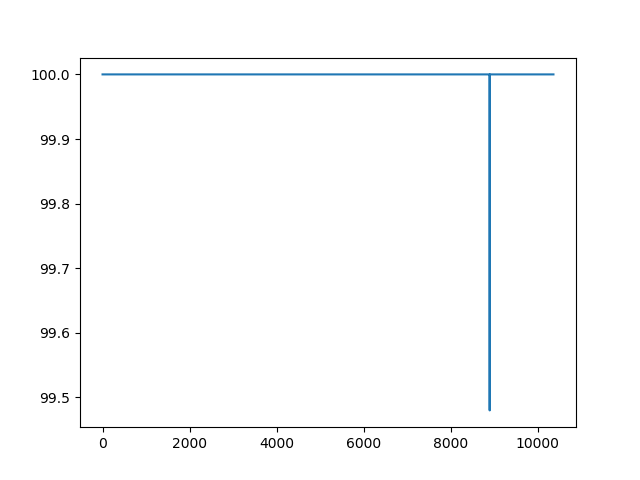

In [142]:
## Look at dff over time in the example voxel
plt.plot(fl[:,ex_ind])

In [40]:
f[0,ex_ind]

100.0